<a href="https://colab.research.google.com/github/urchymanny/machine-learning-and-ai/blob/main/05_TensorFlow_FineTuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image_dataset_from_directory
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

--2024-04-16 19:41:52--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0.001s  

2024-04-16 19:41:52 (11.8 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [2]:
# Get 10% of the data of the 10 classes
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

unzip_data("10_food_classes_10_percent.zip")

# Create training and test directories
train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

# Create data inputs
IMG_SIZE = (224, 224) # define image size
train_data = image_dataset_from_directory(directory=train_dir,
                                          image_size=IMG_SIZE,
                                          label_mode="categorical", # what type are the labels?
                                          batch_size=32) # batch_size is 32 by default, this is generally a good number
test_data = image_dataset_from_directory(directory=test_dir,
                                        image_size=IMG_SIZE,
                                        label_mode="categorical")


--2024-04-16 19:41:53--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.170.207, 173.194.174.207, 74.125.23.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.170.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  29.9MB/s    in 6.2s    

2024-04-16 19:42:00 (26.0 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [3]:
from tensorflow import keras

In [4]:
base_model = tf.keras.applications.EfficientNetB0(include_top=False)

inputs = layers.Input(shape=(224,224,3), name="input_layer")

data_augumentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
  layers.RandomRotation(0.2),
  layers.RandomZoom(0.2),
  layers.RandomHeight(0.2),
  layers.RandomWidth(0.2),
])

# start by augumenting the data
x = data_augumentation(inputs)

# pass aug data into base base model as input
x = base_model(x, training=False)

# pool after data has passed through base model
x = layers.GlobalAveragePooling2D(name="global_average_pooling_2d")(x)

# create the output layer
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)


# create the model
model = tf.keras.Model(inputs, outputs)

# create a checkpoint callback

checkpoint_path = "tmp/checkpoint.ckpt"

ckp_callback = keras.callbacks.ModelCheckpoint(
    checkpoint_path,
    save_weights_only=True,
    save_best_only=True,
    save_freq="epoch",
    verbose=1
)

model.compile(
    loss="categorical_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
)

initial_epoch = 5

history = model.fit(
    train_data,
    epochs=initial_epoch,
    steps_per_epoch=len(train_data),
    validation_data=test_data,
    validation_steps=int(0.25 * len(test_data)),
    callbacks=[ckp_callback]
)

16705208/16705208 [==============================] - 1s 0us/step
Epoch 1/5
24/24 [==============================] - ETA: 0s - loss: 2.0409 - accuracy: 0.2907
Epoch 1: val_loss improved from inf to 1.42594, saving model to tmp/checkpoint.ckpt
24/24 [==============================] - 64s 1s/step - loss: 2.0409 - accuracy: 0.2907 - val_loss: 1.4259 - val_accuracy: 0.5378
Epoch 2/5
24/24 [==============================] - ETA: 0s - loss: 1.3141 - accuracy: 0.5507
Epoch 2: val_loss improved from 1.42594 to 0.99412, saving model to tmp/checkpoint.ckpt
24/24 [==============================] - 20s 826ms/step - loss: 1.3141 - accuracy: 0.5507 - val_loss: 0.9941 - val_accuracy: 0.6760
Epoch 3/5
24/24 [==============================] - ETA: 0s - loss: 1.2708 - accuracy: 0.5840
Epoch 3: val_loss did not improve from 0.99412
24/24 [==============================] - 18s 751ms/step - loss: 1.2708 - accuracy: 0.5840 - val_loss: 1.2746 - val_accuracy: 0.5888
Epoch 4/5
24/24 [===========================

# Finetuning

In [5]:
# For finetuning, we need to unfreeze some layers in the base_model

base_model.trainable = True

# freeze all layers except the last 10 layers
for layer in base_model.layers[:-10]:
  layer.trainable = False


model.compile(
    loss="categorical_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
)

In [6]:
for i, layer in enumerate(model.layers[2].layers):
  print(i, layer.name, layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 rescaling_1 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze False
39

In [7]:
len(model.trainable_variables)

12

In [8]:
fine_tune_epochs = initial_epoch + 5

# refit the model (with more trainable variables) and start off where the last fitting ended
history_2 = model.fit(
    train_data,
    epochs=fine_tune_epochs,
    steps_per_epoch=len(train_data),
    validation_data=test_data,
    validation_steps=int(0.25 * len(test_data)),
    initial_epoch = history.epoch[-1], # added to start off where the last model fitting ended
)

Epoch 5/10
24/24 [==============================] - 14s 280ms/step - loss: 0.3439 - accuracy: 0.8893 - val_loss: 0.8850 - val_accuracy: 0.7632
Epoch 6/10
24/24 [==============================] - 6s 241ms/step - loss: 0.1762 - accuracy: 0.9347 - val_loss: 1.0081 - val_accuracy: 0.7664
Epoch 7/10
24/24 [==============================] - 5s 218ms/step - loss: 0.1122 - accuracy: 0.9693 - val_loss: 0.8927 - val_accuracy: 0.7895
Epoch 8/10
24/24 [==============================] - 6s 229ms/step - loss: 0.0931 - accuracy: 0.9707 - val_loss: 1.0956 - val_accuracy: 0.7812
Epoch 9/10
24/24 [==============================] - 5s 223ms/step - loss: 0.0719 - accuracy: 0.9733 - val_loss: 0.9591 - val_accuracy: 0.7862
Epoch 10/10
24/24 [==============================] - 6s 226ms/step - loss: 0.0738 - accuracy: 0.9720 - val_loss: 1.1907 - val_accuracy: 0.7681


In [9]:
import matplotlib.pyplot as plt

def compare_historys(original_history, new_history, initial_epochs=5):
    """
    Compares two model history objects.
    """
    # Get original history measurements
    acc = original_history.history["accuracy"]
    loss = original_history.history["loss"]

    print(len(acc))

    val_acc = original_history.history["val_accuracy"]
    val_loss = original_history.history["val_loss"]

    # Combine original history with new history
    total_acc = acc + new_history.history["accuracy"]
    total_loss = loss + new_history.history["loss"]

    total_val_acc = val_acc + new_history.history["val_accuracy"]
    total_val_loss = val_loss + new_history.history["val_loss"]

    print(len(total_acc))
    print(total_acc)

    # Make plots
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(total_acc, label='Training Accuracy')
    plt.plot(total_val_acc, label='Validation Accuracy')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(total_loss, label='Training Loss')
    plt.plot(total_val_loss, label='Validation Loss')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

5
11
[0.2906666696071625, 0.5506666898727417, 0.5839999914169312, 0.7239999771118164, 0.8106666803359985, 0.8893333077430725, 0.9346666932106018, 0.9693333506584167, 0.9706666469573975, 0.9733333587646484, 0.972000002861023]


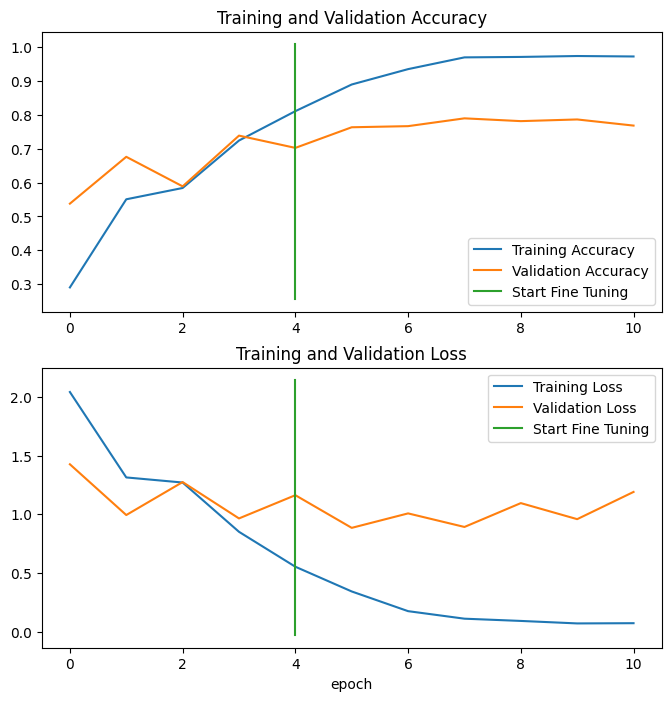

In [10]:
compare_historys(history, history_2)

# Model 4: Finetuning existing model with 100% of the data

In [11]:
# Get 10% of the data of the 10 classes
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip

unzip_data("10_food_classes_all_data.zip")

# Create training and test directories
train_dir = "10_food_classes_all_data/train/"
test_dir = "10_food_classes_all_data/test/"

# Create data inputs
IMG_SIZE = (224, 224) # define image size
train_data = image_dataset_from_directory(directory=train_dir,
                                          image_size=IMG_SIZE,
                                          label_mode="categorical", # what type are the labels?
                                          batch_size=32) # batch_size is 32 by default, this is generally a good number
test_data = image_dataset_from_directory(directory=test_dir,
                                        image_size=IMG_SIZE,
                                        label_mode="categorical")

--2024-04-16 19:45:04--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.8.207, 142.251.170.207, 173.194.174.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.8.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip’

10_food_classes_all 100%[===================>] 495.13M  27.7MB/s    in 19s     

2024-04-16 19:45:23 (26.3 MB/s) - ‘10_food_classes_all_data.zip’ saved [519183241/519183241]

Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [16]:
model.load_weights("tmp/checkpoint.ckpt")
print(f"TensorFlow version: {tf.__version__}")

ValueError: Received incompatible tensor with shape (3, 3, 3, 32) when attempting to restore variable with shape (1, 1, 1152, 48) and name Adam/m/block7a_se_reduce/kernel:0.